<a href="https://colab.research.google.com/github/sciencelee/mod4-xray-pneumonia-ML/blob/main/mod4_xrays.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
In this project we will create a Machine Learning model to classify chest x-ray images as positive or negative for pneumonia.  

In [4]:
!git clone https://github.com/sciencelee/mod4-xray-pneumonia-ML


Cloning into 'mod4-xray-pneumonia-ML'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 6 (delta 0), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


# Dataset
The full dataset used in this project can be found [here](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) at kaggle.com.  

The kaggle dataset is taken adapted from the [original images](https://data.mendeley.com/datasets/rscbjbr9sj/3) at Mendeley Data.

The labeled dataset contains 1583 normal chest xray images, and 4274 with pneumonia. The original images are greater than 1200x1200 pixels grayscale.

#Project Setup


##Google Drive 
This project is written in Google Colab.  The image folders are stored in These blocks mount the users google drive.  The chest xrays are stored in the path location of the drive.

The structure of the xray images within the google folder is as shown. If you would like to recreate the project, all normal labeled images go in the "NORMAL ALL" folder, and all pneumonia labeled go in the 'PNEUMONIA ALL' folder.  This notebook will randomly place the desired `train test val` ratios of randomized images into the correct folders for reading into the datasets used in our model.  

```
chest_xray  
  └───NORMAL_ALL (contains all normal imgs)
  └───PNEUMONIA_ALL (contains all pneumonia imgs)
  └───train 
  │   └───NORMAL
  │   └───PNEUMONIA
  └───test
  │   └───NORMAL
  │   └───PNEUMONIA
  └───val
      └───NORMAL
      └───PNEUMONIA
```

The code below connects this ipynb to Google Drive.  To give access to your drive, you will need to give authorization.

In [3]:
from google.colab import drive # import drive from google colab

drive.mount('/content/drive') # we mount the google drive at /content/drive

ValueError: ignored

## Imports
Import all of the necessary libraries.

In [ ]:
import datetime
import os
import time
import shutil
import datetime
from random import shuffle, seed


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from PIL import Image
import scipy
from scipy import ndimage
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.preprocessing import image
from keras.models import load_model
from keras.utils import plot_model


%matplotlib inline

np.random.seed(123)

In [ ]:

'''
chest_xray  
  └───NORMAL_ALL (contains all normal imgs)
  └───PNEUMONIA_ALL (contains all pneumonia imgs)
  └───train 
  │   └───NORMAL
  │   └───PNEUMONIA
  └───test
  │   └───NORMAL
  │   └───PNEUMONIA
  └───val
      └───NORMAL
      └───PNEUMONIA
'''
pass


In [ ]:
path = '/content/drive/MyDrive/chest_xray'
all_normal_folder = path + '/NORMAL_ALL/'
all_pneumonia_folder = path + '/PNEUMONIA_ALL/'

test_folder = path + '/test/'
train_folder = path + '/train/'
val_folder = path + '/val/'

## Building our Train, Test, and Validation Datasets
We will make lists of all of the image names for NORMAL and PNEUMONIA chest xrays.  Then we can divy up the images into individual folders for later use.

I will also use this opportunity to randomize the images, and select the size of the dataset to use.  I will start with a small sets prior to building the final model.

We have two folders.  One for normal images, and one for pnemonia xray images

In [ ]:
seed(123)

# Make a list of all normal images
normal_imgs = [file for file in os.listdir(all_normal_folder)]
shuffle(normal_imgs) # random lib method for iterables
normal_imgs[:10]

print('There are {} normal xray images.'.format(len(normal_imgs)))


# make a list of all pneumonia images
pneumonia_imgs = [file for file in os.listdir(all_pneumonia_folder)]
shuffle(pneumonia_imgs)
pneumonia_imgs[:10]

all_imgs = normal_imgs + pneumonia_imgs
shuffle(all_imgs)

print('There are {} pneumonia xray images.'.format(len(pneumonia_imgs)))


There are 1583 normal xray images.


In [ ]:
# https://docs.python.org/3/library/shutil.html#shutil

# set distribution of datasets
train_test_val = [0.8, 0.1, 0.1] # must add to 1.0

# What percentage of the dataset are we using
size_dataset = 1 # what percentage of dataset are we using?

# NORMAL data indices
# indices for train, test, val
n_images_norm = int(round(len(normal_imgs) * size_dataset))

print(
'''
Percent of images used: {:.0%}. (to speed up model iterations)
Train//Test//Val Split: {:.0%}, {:.0%}, {:.0%}
'''.format(size_dataset, train_test_val[0], train_test_val[1], train_test_val[2]))

# get the correct indices to chop up my NORMAL images from a shuffled list
norm_train_index = int(round(n_images_norm * train_test_val[0]))
norm_test_index = int(norm_train_index + round(n_images_norm * train_test_val[1]))
norm_val_index = min(norm_test_index + int(round(n_images_norm * train_test_val[2])), n_images_norm-1)

print('NORMAL xrays\nTotal images: {}\nIndices: {}, {}, {}'.format(n_images_norm, norm_train_index, norm_test_index, norm_val_index)) 

# PNEUMONIA data indices
# indices for train, test, val
n_images_pneu = int(round(len(pneumonia_imgs) * size_dataset))

# get the correct indices to chop up my PNEUMONIA images from a shuffled list
pneu_train_index = int(round(n_images_pneu * train_test_val[0]))
pneu_test_index = int(pneu_train_index + round(n_images_pneu * train_test_val[1]))
pneu_val_index = min(pneu_test_index + int(round(n_images_pneu * train_test_val[2])), n_images_pneu-1)


print('\nPNEUMONIA xrays\nTotal images: {}\nIndices: {}, {}, {}'.format(n_images_pneu, pneu_train_index, pneu_test_index, pneu_val_index)) 

Now that we have all of the names of images in a list, and we have the indices for the split, we will copy image files into the appropriate folders so we can use 'flow_from_directory' method in ImageDataGenerator.

This may take a while.  This is definitely not something I would try on a larger dataset, but it works for this size and gives us some flexibility in training the model.

In [ ]:
# ONLY RUN THIS CELL IF YOU WANT TO RECREATE THE DATASET
# ⏰ ⏰
answer = input("Are you sure you want to continue?")

if answer.upper() in ['Y', 'YES']:

  # empty all of the folders first
  shutil.rmtree(test_folder, ignore_errors=True)
  shutil.rmtree(train_folder, ignore_errors=True)
  shutil.rmtree(val_folder, ignore_errors=True)

  os.mkdir(test_folder)
  os.mkdir(test_folder + 'NORMAL')
  os.mkdir(test_folder + 'PNEUMONIA')
  os.mkdir(train_folder)
  os.mkdir(train_folder + 'NORMAL')
  os.mkdir(train_folder + 'PNEUMONIA')
  os.mkdir(val_folder)
  os.mkdir(val_folder + 'NORMAL')
  os.mkdir(val_folder + 'PNEUMONIA')

  # fill them back up with selected images

  # NORMAL images first
  for image in normal_imgs[:norm_train_index]:
    shutil.copyfile(all_normal_folder + image, train_folder + 'NORMAL/' + image)
  else:
    print(train_folder + 'NORMAL', 'complete')

  for image in normal_imgs[norm_train_index:norm_test_index]:
    shutil.copyfile(all_normal_folder + image, test_folder + 'NORMAL/' + image)
  else:
    print(test_folder + 'NORMAL', 'complete')

  for image in normal_imgs[norm_test_index:norm_val_index]:
    shutil.copyfile(all_normal_folder + image, val_folder + 'NORMAL/' + image)
  else:
    print(val_folder + 'NORMAL', 'complete')

  # PNEUMONIA images
  for image in pneumonia_imgs[:pneu_train_index]:
    shutil.copyfile(all_pneumonia_folder + image, train_folder + 'PNEUMONIA/' + image)
  else:
    print(train_folder + 'PNEUMONIA', 'complete')

  for image in pneumonia_imgs[pneu_train_index:pneu_test_index]:
    shutil.copyfile(all_pneumonia_folder + image, test_folder + 'PNEUMONIA/' + image)
  else:
    print(test_folder + 'PNEUMONIA', 'complete')

  for image in pneumonia_imgs[pneu_test_index:pneu_val_index]:
      shutil.copyfile(all_pneumonia_folder + image, val_folder + 'PNEUMONIA/' + image)
  else:
    print(val_folder + 'PNEUMONIA', 'complete')

KeyboardInterrupt: ignored

In [ ]:
# Original image investigation
filename = all_normal_folder + os.listdir(all_normal_folder)[337]
sample_img = plt.imread(filename)

plt.figure(figsize=[16,8])
plt.subplot(121) 
plt.imshow(sample_img, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Grayscale')

plt.subplot(122) 
plt.imshow(sample_img, cmap='Spectral_r')
plt.colorbar()
plt.title('Raw Chest X Ray Spectral')

print("{}x{} image. Single color channel.".format(sample_img.shape[0], sample_img.shape[1]))
print('Max pixel value: {}\nMin pixel value: {}'.format(sample_img.max(), sample_img.min()))
print('Mean value: {:.2f}\nStd Dev: {:.2f}'.format(sample_img.mean(), sample_img.std()))

In [ ]:
# get all the data in the directory and downsample it

n = len(os.listdir(test_folder + 'PNEUMONIA')) + len(os.listdir(test_folder + 'NORMAL'))
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_folder, 
        target_size=(150, 150),
        batch_size=n
        ) 

n = len(os.listdir(val_folder + 'PNEUMONIA')) + len(os.listdir(val_folder + 'NORMAL'))
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_folder, 
        target_size=(150, 150),
        batch_size=n
        )

n = len(os.listdir(train_folder + 'PNEUMONIA')) + len(os.listdir(train_folder + 'NORMAL'))
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_folder, 
        target_size=(150, 150),
        batch_size=n
        )


##### 
# I WANT TO SWITCH THIS TO MAYBE AN 80/10/10 ratio in the folders

In [ ]:
# create the data sets. 
# ⏰ ⏰ ⏰ ⏰ 
test_images, test_labels = next(test_generator)
print('Test')
val_images, val_labels = next(val_generator)
print('Val')
train_images, train_labels = next(train_generator)
print('Train')



In [ ]:
# LITTLE EDA ON DOWNSAMPLED PICS

plt.figure(figsize=(16,16))  # change the size of figure!

for i in range(16):
    img = train_images[i]
    image_label = 'NORMAL' if train_labels[i][1] == 0 else 'PNEUMONIA'

    plt.subplot(4, 4, i+1)
    plt.imshow(img)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
    plt.title(image_label)  # Plot title here!!!

plt.show()

In [ ]:
# This block grabs some basic stats for all downsampled images

def print_stats(title, my_stats, pixels, n):
    print(title + " Pixel Intensity (n = {})".format(n))
    print('Mean:             {:.3f}'.format(my_stats[0]))
    print('Std:              {:.3f}'.format(my_stats[1]))
    print('Black (0) Pixels: {:.2f}%'.format(my_stats[2] / pixels * 100))
    print('White (1) Pixels: {:.2f}%'.format(my_stats[3] / pixels * 100))


def some_stats(images, labels):
  p_stats = [0, 0, 0, 0] # mean std black white
  n_stats = [0, 0, 0, 0]
  n_p = 0 # n pneu
  n_n = 0 # n normal
  pixels = len(images[0]) * len(images[0][0]) * 3 #3 channels

  for i in range(len(images)):
      my_img = images[i].flatten()
      if labels[i][1] == 1:
          n_p += 1
          p_stats[0] += my_img.mean()
          p_stats[1] += np.std(my_img)
          p_stats[2] += np.count_nonzero(my_img == 0)
          p_stats[3] += np.count_nonzero(my_img == 1)

      else:
          n_n += 1
          n_stats[0] += img.mean()
          n_stats[1] += img.std()
          n_stats[2] += np.count_nonzero(my_img == 0)
          n_stats[3] += np.count_nonzero(my_img == 1)

  else:
    n_stats = np.array(n_stats) / n_n
    p_stats = np.array(p_stats) / n_p
  
  weight_normal = n_n / (n_n + n_p)
  weight_pneumonia = 1 - weight_normal 
  print('Dataset Imbalance: {:.1f} Normal, {:.1f} Pneumonia'.format(weight_normal * 100, weight_pneumonia * 100))
  print()
  print_stats('Normal', n_stats, pixels, n_n)
  print()
  print_stats('Pneumonia', p_stats, pixels, n_p)

# function just prints out some stats of interest from downsampled data
some_stats(train_images, train_labels)

In [ ]:
train_images[0].shape

In [ ]:
# Explore your dataset again
m_train = train_images.shape[0]
num_px = train_images.shape[1]
m_test = test_images.shape[0]
m_val = val_images.shape[0]

print ("Number of training samples: " + str(m_train))
print ("Number of testing samples: " + str(m_test))
print ("Number of validation samples: " + str(m_val))
print ("train_images shape: " + str(train_images.shape))
print ("train_labels shape: " + str(train_labels.shape))
print ("test_images shape: " + str(test_images.shape))
print ("test_labels shape: " + str(test_labels.shape))
print ("val_images shape: " + str(val_images.shape))
print ("val_labels shape: " + str(val_labels.shape))

In [ ]:
# SKIP ME
train_img = train_images.reshape(train_images.shape[0], -1)
test_img = test_images.reshape(test_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

print(train_img.shape)
print(test_img.shape)
print(val_img.shape)

# crop down images as experiment
train_images[0].shape
crop_train_images = np.array([x[20:120, :, :] for x in train_images]) # height, width, channels
crop_train_img = crop_train_images.reshape(crop_train_images.shape[0], -1)
print(train_images[0].shape)
print(crop_train_images[0].shape)

crop_test_images = np.array([x[20:120, :, :] for x in test_images])
crop_test_img = crop_test_images.reshape(crop_test_images.shape[0], -1)

crop_val_images = np.array([x[20:120, :, :] for x in val_images])
crop_val_img = crop_val_images.reshape(crop_val_images.shape[0], -1)

In [ ]:
for i in range(10):
  my_img = crop_train_images[i]
  plt.imshow(my_img)
  plt.show()

In [ ]:

for i in range(10):
  plt.figure(figsize=(12,6))  # change the size of figure!
  plt.subplot(121)
  my_img = train_images[i]
  classification = 'Normal' if train_labels[i][1]==0 else 'Pneumonia'

  plt.imshow(my_img)
  plt.title(classification)
  label = "Mean: {:.2f}, SD: {:.2f} Label: {}".format(np.mean(my_img), np.std(my_img), classification)
  
  plt.subplot(122)
  sns.distplot(my_img,
              label=label,
              kde=False)
  plt.legend()
  plt.title('Pixel Intensity of X-ray Images')
  plt.xlabel('Pixel Intensity')
  plt.ylabel('Total Pixels')
  plt.show()



In [ ]:
train_y = np.reshape(train_labels[:,0], (train_img.shape[0],1))
test_y = np.reshape(test_labels[:,0], (test_img.shape[0],1))
val_y = np.reshape(val_labels[:,0], (val_img.shape[0],1))

# same for crop I thing

In [ ]:
# Build a baseline fully connected model

np.random.seed(123)
model = models.Sequential()
model.add(layers.Dense(20, activation='relu', input_shape=(67500,))) # 2 hidden layers
model.add(layers.Dense(7, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
# CROP EXPERIMENT
# Build a baseline fully connected model

np.random.seed(123)
crop_model = models.Sequential()
crop_model.add(layers.Dense(20, activation='relu', input_shape=(100*150*3,))) # 2 hidden layers
crop_model.add(layers.Dense(7, activation='relu'))
crop_model.add(layers.Dense(5, activation='relu'))
crop_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(train_img,
                    train_y,
                    epochs=50,
                    batch_size=20,
                    steps_per_epoch=100,
                    validation_data=(val_img, val_y))

In [ ]:
# CROP EXPERIMENT

crop_model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = crop_model.fit(crop_train_img,
                    train_y,
                    epochs=50,
                    batch_size=20,
                    steps_per_epoch=100,
                    validation_data=(crop_val_img, val_y))

That's a pretty good first result using 50% of dataset we achieved 90.0% on test set.

With entire dataset, we achieved 92.8%



In [ ]:
results_train = model.evaluate(train_img, train_y)
print(results_train)

results_test = model.evaluate(test_img, test_y)
print(results_test)

In [ ]:
# Experimenting with cropping??

results_train = crop_model.evaluate(crop_train_img, train_y)
print(results_train)

results_test = crop_model.evaluate(crop_test_img, test_y)
print(results_test)

## Build the CNN

In [ ]:


original_start = datetime.datetime.now()
start = datetime.datetime.now()

In [ ]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_folder,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(val_folder,
                                                        target_size=(150, 150),
                                                        batch_size=20,
                                                        class_mode='binary')



In [ ]:


model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))

model2.add(layers.Dense(1, activation='sigmoid'))

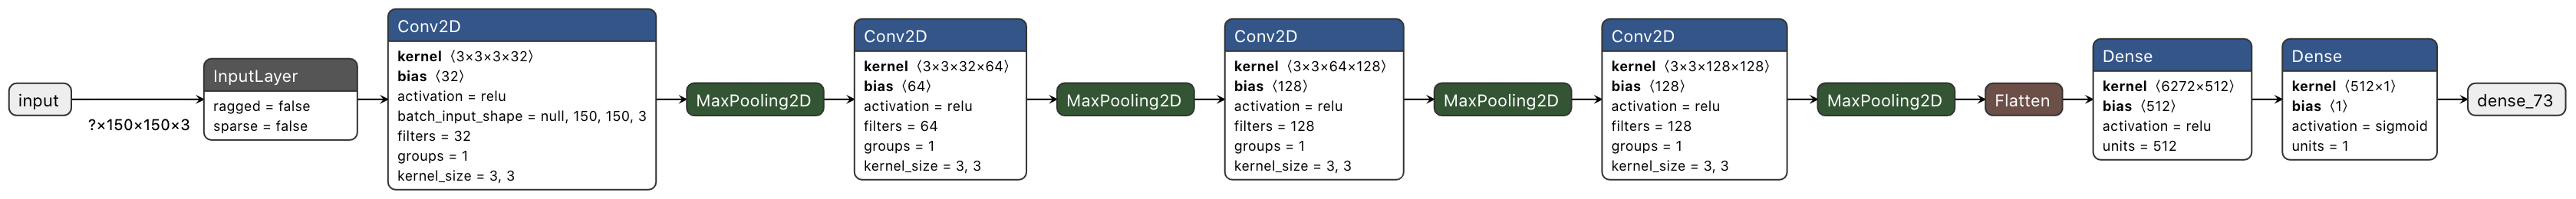

In [ ]:

model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

#Training and evaluation

In [ ]:
# ⏰ This cell may take several minutes to run
history2 = model2.fit(train_generator, 
                              steps_per_epoch=100, 
                              epochs=100, 
                              validation_data=validation_generator, 
                              validation_steps=50)

Epoch 1/100
100/100 [==============================] - 120s 1s/step - loss: 0.4501 - acc: 0.7920 - val_loss: 0.2957 - val_acc: 0.8701
Epoch 2/100
100/100 [==============================] - 106s 1s/step - loss: 0.2671 - acc: 0.8925
Epoch 3/100
100/100 [==============================] - 107s 1s/step - loss: 0.2022 - acc: 0.9230
Epoch 4/100
100/100 [==============================] - 106s 1s/step - loss: 0.1787 - acc: 0.9240
Epoch 5/100
100/100 [==============================] - 106s 1s/step - loss: 0.1597 - acc: 0.9385
Epoch 6/100
100/100 [==============================] - 106s 1s/step - loss: 0.1674 - acc: 0.9325
Epoch 7/100
100/100 [==============================] - 107s 1s/step - loss: 0.1350 - acc: 0.9535
Epoch 8/100
100/100 [==============================] - 107s 1s/step - loss: 0.1495 - acc: 0.9445
Epoch 9/100
100/100 [==============================] - 108s 1s/step - loss: 0.1355 - acc: 0.9465
Epoch 10/100
100/100 [==============================] - 106s 1s/step - loss: 0.1224 - acc:

In [ ]:
history2.history

{'acc': [0.8863179087638855,
  0.9024145007133484,
  0.9144869446754456,
  0.9390000104904175,
  0.9315895438194275,
  0.9399999976158142,
  0.9476861357688904,
  0.9449999928474426,
  0.9470000267028809,
  0.9446679949760437,
  0.949999988079071,
  0.9507042169570923,
  0.9486921429634094,
  0.9580000042915344,
  0.9649999737739563,
  0.9567404389381409,
  0.9647887349128723,
  0.9599999785423279,
  0.968812882900238,
  0.968999981880188],
 'loss': [0.26900139451026917,
  0.22198349237442017,
  0.19621245563030243,
  0.17067980766296387,
  0.16919320821762085,
  0.16040924191474915,
  0.13726185262203217,
  0.14122334122657776,
  0.13388510048389435,
  0.1440018266439438,
  0.1267293393611908,
  0.11510766297578812,
  0.11839642375707626,
  0.10649406164884567,
  0.09181804955005646,
  0.11125336587429047,
  0.09108427911996841,
  0.08890698105096817,
  0.07721123844385147,
  0.08441054821014404]}

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [ ]:


print(history2.history)

acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

{'loss': [0.26900139451026917, 0.22198349237442017, 0.19621245563030243, 0.17067980766296387, 0.16919320821762085, 0.16040924191474915, 0.13726185262203217, 0.14122334122657776, 0.13388510048389435, 0.1440018266439438, 0.1267293393611908, 0.11510766297578812, 0.11839642375707626, 0.10649406164884567, 0.09181804955005646, 0.11125336587429047, 0.09108427911996841, 0.08890698105096817, 0.07721123844385147, 0.08441054821014404], 'acc': [0.8863179087638855, 0.9024145007133484, 0.9144869446754456, 0.9390000104904175, 0.9315895438194275, 0.9399999976158142, 0.9476861357688904, 0.9449999928474426, 0.9470000267028809, 0.9446679949760437, 0.949999988079071, 0.9507042169570923, 0.9486921429634094, 0.9580000042915344, 0.9649999737739563, 0.9567404389381409, 0.9647887349128723, 0.9599999785423279, 0.968812882900238, 0.968999981880188]}


KeyError: ignored

The accuracy with just 50% of the dataset is over 96% (training acc).  Let's see how it performs with new data.

In [ ]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:24:38.446406


In [ ]:
model2.save('/content/drive/MyDrive/chest_xray/chest_xray_cnn_100_801010.h5')


NameError: ignored

In [ ]:
test_generator = test_datagen.flow_from_directory(test_folder, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

test_loss, test_acc = model2.evaluate_generator(test_generator, steps=10)
print('test acc:', test_acc)

Found 585 images belonging to 2 classes.
Instructions for updating:
Please use Model.evaluate, which supports generators.
test acc: 0.9549999833106995


In [ ]:
model.predict()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
# I want to try a dropout strategy.  Not sure if it applies here

model3 = models.Sequential()


model3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.2))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
#model3.add(layers.Dropout(0.2))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
#model3.add(layers.Dropout(0.2))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
history3 = model3.fit_generator(train_generator, 
                              steps_per_epoch=50, 
                              epochs=20, 
                              validation_data=validation_generator, 
                              validation_steps=20)

Epoch 1/20
50/50 [==============================] - 59s 1s/step - loss: 0.5674 - acc: 0.7324 - val_loss: 0.6299 - val_acc: 0.7468
Epoch 2/20
50/50 [==============================] - 54s 1s/step - loss: 0.4624 - acc: 0.8008
Epoch 3/20
50/50 [==============================] - 54s 1s/step - loss: 0.3320 - acc: 0.8520
Epoch 4/20
50/50 [==============================] - 57s 1s/step - loss: 0.2889 - acc: 0.8783
Epoch 5/20
50/50 [==============================] - 54s 1s/step - loss: 0.2567 - acc: 0.8930
Epoch 6/20
50/50 [==============================] - 54s 1s/step - loss: 0.2360 - acc: 0.9095
Epoch 7/20
50/50 [==============================] - 54s 1s/step - loss: 0.2319 - acc: 0.9095
Epoch 8/20
50/50 [==============================] - 54s 1s/step - loss: 0.2046 - acc: 0.9165
Epoch 9/20
50/50 [==============================] - 54s 1s/step - loss: 0.1915 - acc: 0.9240
Epoch 10/20
50/50 [==============================] - 54s 1s/step - loss: 0.1735 - acc: 0.9400
Epoch 11/20
50/50 [=============

In [ ]:
test_generator = test_datagen.flow_from_directory(test_folder, 
                                                  target_size=(150, 150), 
                                                  batch_size=20, 
                                                  class_mode='binary')

test_loss, test_acc = model3.evaluate_generator(test_generator, steps=10)
print('test acc:', test_acc)

Found 234 images belonging to 2 classes.
test acc: 0.8899999856948853


In [ ]:
model3.save('/content/drive/MyDrive/chest_xray/chest_xray_cnn_dropout_40_801010.h5')

Make a quick evaluator for new images

In [ ]:
# we can now load the saved model

model = load_model('/content/drive/MyDrive/chest_xray/chest_xray_cnn_50_801010.h5')



NameError: ignored

In [ ]:
#this is so we can send it to flask
model.deploy_model(description='Final model',
                author="Aaron Lee", organisation='Flatiron',
                file_name='xrays.sav')

In [ ]:


correct = 0
incorrect = 0

print("{:12}{:12}{:12}{:12}".format('Label', 'Prediction', 'Float', 'Correct?'))

# go through some images and predict them individually.
for i in range(len(test_images)):
  img = test_images[i]
  #print(img.shape)
  img = img.reshape(-1, 150,150, 3)

  #print(type(test_labels[i][0]))
  if test_labels[i][1] > 0:
    image_label = 'NORMAL'
  else:
    image_label = 'PNEUMONIA'
  #image_label = 'NORMAL' if test_labels[i][1] == 0 else 'PNEUMONIA'


  result = model2.predict(img)
  pred_float = result[0][0]

  if result[0].round() > 0:
    prediction = 'NORMAL'
  else:
    prediction = 'PNEUMONIA'  
  
  print('{:12}{:12}{:<12.2f}'.format(image_label, prediction, pred_float), end=' ')

  if prediction == image_label:
    correct += 1
    print("\U0001F603") 
  else:
    incorrect += 1
    print(u'\u274C')


  

print(correct / (correct + incorrect))




Label       Prediction  Float       Correct?    


NameError: ignored

In [ ]:
print(len(test_images))   


234


In [ ]:
test_images.reshape(67500,-1).shape
#train_img.shape

(67500, 585)

In [ ]:
# CONFUSION MATRIX AND SCORING

preds = model2.predict(test_images) # Use your best model. For CNN I used test_images, for baseline I used test_img
#acc = accuracy_score(test_y, np.round(preds))*100 
acc = (1-accuracy_score(test_y, np.round(preds)))*100  # my test_y is backwards for model2!!
cm = confusion_matrix(test_y, np.round(preds))
fn, tp, tn, fp = cm.ravel()

print('Confusion matrix')
print(cm)

print('\nMETRICS:')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {:.2f}%'.format(acc))
print('Precision: {:.2f}%'.format(precision))
print('Recall: {:.2f}%'.format(recall))
print('F1-score: {:.2f}'.format(2*precision*recall/(precision+recall)))


Confusion matrix
[[  7 420]
 [140  18]]

METRICS:
Accuracy: 95.73%
Precision: 95.89%
Recall: 98.36%
F1-score: 97.11


In [ ]:
hist.history.keys()
#model.predict(train_img) # Pick the best model

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Chest X-ray Confusion Matrix')

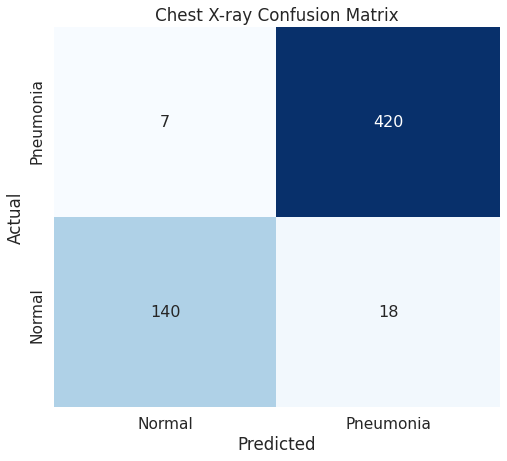

In [ ]:


df_cm = pd.DataFrame(cm, columns=np.unique(test_y), index = np.unique(test_y))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (8,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g', cbar=False)# font size
plt.xticks([0.5, 1.5], ['Normal', 'Pneumonia'])
plt.yticks([0.3, 1.4], ['Pneumonia', 'Normal'])
plt.title('Chest X-ray Confusion Matrix')


In [ ]:
len(os.listdir(all_normal_folder))

1583

In [ ]:
len(os.listdir(all_pneumonia_folder))

4274

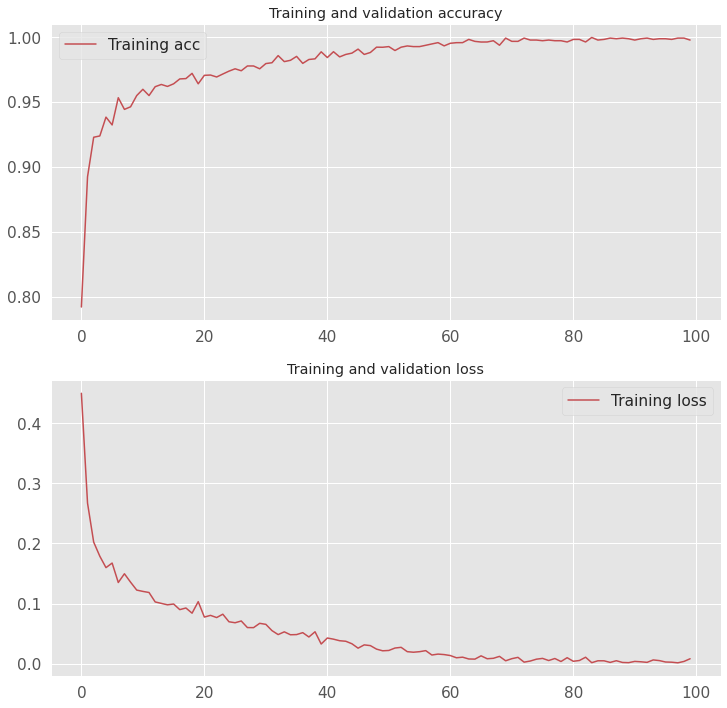

In [ ]:

#print(hist.history.keys())

plt.style.use('ggplot')

plt.figure(figsize=[12,12])
plt.subplot(211)
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
#plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(212)
plt.plot(epochs, loss, 'r', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
history2.history['val_acc']

[0.8700854778289795]

In [ ]:
history2.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
# PREDICTION MACHINE

model2.predict(np.array([test_images[13]]))[0][0].round()

1.0

In [ ]:
model2.predict(test_images[0])

ValueError: ignored

In [ ]:
model2.predict?

In [ ]:
test_images[0].shape

(150, 150, 3)

In [ ]:
my_model = load_model('/content/drive/MyDrive/chest_xray/chest_xray_cnn_100_801010.h5')  # model is CNN trained with 5k+ images
